# Homework 2 - IEEE Fraud Detection

For all parts below, answer all parts as shown in the Google document for Homework 2. Be sure to include both code that justifies your answer as well as text to answer the questions. We also ask that code be commented to make it easier to follow.

## Part 1 - Fraudulent vs Non-Fraudulent Transaction

In [152]:
# Taking all imports for processing
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split

In [125]:
# loading train-data in dataframes
train_identity_df = pd.read_csv("../data/train_identity.csv")
train_transaction_df = pd.read_csv("../data/train_transaction.csv")
global_df = pd.merge(left=train_transaction_df, right=train_identity_df, left_on=["TransactionID"],
                                       right_on="TransactionID", how="left")
# Since Part 1 to 5 would only involve following fields
# TransactionID,DeviceType,DeviceInfo,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,dist2
# Loading above necessary fields into base dataframe
# And performing EDA on these data
basic_fields_df = global_df[["TransactionID", "TransactionDT", "TransactionAmt",
                                              "ProductCD", "card4", "card6", "P_emaildomain", "R_emaildomain", 
                                              "addr1", "addr2", "dist1", "dist2", "isFraud", "DeviceType", "DeviceInfo"]]

In [3]:
fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 1]
non_fraudulent_df = basic_fields_df[basic_fields_df.isFraud == 0]
rows_in_fraud = fraudulent_df.shape[0]
rows_in_non_fraud = non_fraudulent_df.shape[0]
total_rows = basic_fields_df.shape[0]
print("Fraudulent instances: {0} | Non Fraudulent instances: {1}".format(str(rows_in_fraud), str(rows_in_non_fraud)))

Fraudulent instances: 20663 | Non Fraudulent instances: 569877


In [4]:
# Cite: https://stackoverflow.com/questions/41681693/pandas-isnull-sum-with-column-headers

### Comparing nulls between fraudulent and non-fraudulent data-set ###

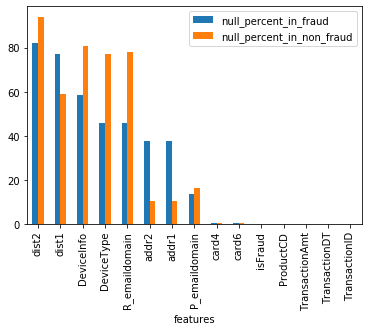

In [5]:
# isnull() returns boolean array for each row
# sum() on isnull() groups null values and take their sum returning a Series
# the Series returned has null value for each column (which can be seen as index for that value in Series)
# In the end, we take transpose() to convert index to column and corresponding row in Series to cell Value for that column
non_fraudulent_null_stats = non_fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_non_fraud_nulls = non_fraudulent_null_stats * 100.0 / rows_in_non_fraud
percent_non_fraud_nulls = percent_non_fraud_nulls.reset_index()
percent_non_fraud_nulls = percent_non_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

fraudulent_null_stats = fraudulent_df.isnull().sum().sort_values(ascending=False)
percent_fraud_nulls = fraudulent_null_stats * 100.0/ rows_in_fraud
percent_fraud_nulls = percent_fraud_nulls.reset_index()
percent_fraud_nulls = percent_fraud_nulls.rename(columns={'index': 'features', 0: 'null_percent'})

total_null_stats = pd.merge(percent_fraud_nulls, percent_non_fraud_nulls, on='features', suffixes=['_in_fraud', '_in_non_fraud'])

total_null_stats.plot.bar(x='features')

In [6]:
total_null_stats.head(20)

,features,null_percent_in_fraud,null_percent_in_non_fraud
0,dist2,81.943571,94.052050
1,dist1,76.987853,59.023789
2,DeviceInfo,58.345836,80.687236
3,DeviceType,45.743600,77.258426
4,R_emaildomain,45.666167,77.878735
5,addr2,37.463098,10.171493
6,addr1,37.463098,10.171493
7,P_emaildomain,13.502396,16.085225
8,card4,0.198422,0.269532
9,card6,0.188743,0.268830


### Observations ###
1. Just like the non-fraud transactions, majority of null values in fraud transactions are from distances, devices and email addresses.
2. The key difference is in the field of `DeviceInfo` (Windows/Mac OS), `DeviceType` (mobile, desktop), `R_emaildomain` (receipient email).
  
    a. For fraud transaction `null` values for DeviceInfo is around 58% of its set, whereas for non-fraud transactions its around 80%. 
  
    b. For fraud transaction `null` values for DeviceType is around 45% of its set, whereas for non-fraud transaction its around 77%.
  
    c. Also receipent email address are `null` for 45% of its set, whereas for non-fraud transaction its 77%.
  
  ### Conclusion (from visualization around null values in Fraud transactions and Non-Fraud transactions) ###
 One possible explanation for above discrepancy could be: the values for above details like email address are usually not provided or deferred by benevolent transactions, but a fraudster may have provided fake values instead of ignoring like a regular transactor. This in-turn reduced `null` values for fraud transactions.

In [7]:
# https://stackoverflow.com/questions/51749208/plotting-two-histograms-from-a-pandas-dataframe-in-one-subplot-using-matplotlib

## Observing max-min-std of the fields among fraud vs non-fraud transactions ##

In [8]:
fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,2.066300e+04,2.066300e+04,20663.000000,12922.000000,12922.000000,4755.000000,3731.000000,20663.0
mean,3.294952e+06,7.690033e+06,149.244779,294.317134,86.286024,174.588854,201.472259,1.0
std,1.620403e+05,4.416551e+06,232.212163,103.584955,4.936238,424.232313,451.589576,0.0
min,2.987203e+06,8.976000e+04,0.292000,110.000000,10.000000,0.000000,0.000000,1.0
25%,3.167366e+06,3.965858e+06,35.044000,204.000000,87.000000,3.000000,7.000000,1.0
50%,3.291934e+06,7.575230e+06,75.000000,299.000000,87.000000,10.000000,49.000000,1.0
75%,3.428646e+06,1.121743e+07,161.000000,330.000000,87.000000,85.500000,233.000000,1.0
max,3.577526e+06,1.581088e+07,5191.000000,536.000000,96.000000,4942.000000,9337.000000,1.0


In [9]:
non_fraudulent_df.describe()

,TransactionID,TransactionDT,TransactionAmt,addr1,addr2,dist1,dist2,isFraud
count,5.698770e+05,5.698770e+05,569877.000000,511912.000000,511912.000000,233514.000000,33896.000000,569877.0
mean,3.281810e+06,7.360791e+06,134.511665,290.643341,86.813620,117.360098,235.199758,0.0
std,1.707548e+05,4.623930e+06,239.395078,101.692564,2.607742,370.641879,536.798492,0.0
min,2.987000e+06,8.640000e+04,0.251000,100.000000,13.000000,0.000000,0.000000,0.0
25%,3.133317e+06,3.010651e+06,43.970000,204.000000,87.000000,3.000000,7.000000,0.0
50%,3.281808e+06,7.271678e+06,68.500000,299.000000,87.000000,8.000000,36.000000,0.0
75%,3.429974e+06,1.125334e+07,120.000000,330.000000,87.000000,24.000000,206.000000,0.0
max,3.577539e+06,1.581113e+07,31937.391000,540.000000,102.000000,10286.000000,11623.000000,0.0


## Conclusion ##


1.   The max value of `TransactionAmt` for fraudulent transactions is 5191, whereas for non-fraudulent transaction it is 31937 (which is roughly 6 times). This suggests that fraudulent transactions are possibly done in smaller denominations may be to avoid flagging or alerting existing Fraud-Detection Systems 
2.   The max value of `dist1` for fraudulent transactions is 4942, whereas for non-fraudulent transaction it is 10286 (which is roughly twice). It suggests that either the fraudster did frauds at smaller distances or  fraudster recorded fake details regarding address or distances in their order details of locations they are aware of (possibly closer to their residences)
3.   The standard deviation of `addr2` of fraudulent transactions is 4.93, whereas for non-fraudulent transactions is 2.6 (which is roughly half). This indicates that the spread of billing region or billing country details for fraudulent transactions is much higher may be because the fraudster were faking their details



## Part 2 - Transaction Frequency

### https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
### https://stackoverflow.com/questions/21441259/pandas-groupby-range-of-values

In [23]:
country_code_freq = basic_fields_df['addr2'].value_counts()
country_code_freq = country_code_freq.rename_axis('country_code').reset_index(name='country_transaction_counts')
country_code_freq.head()

,country_code,country_transaction_counts
0,87.0,520481
1,60.0,3084
2,96.0,638
3,32.0,91
4,65.0,82


### Maximum transaction country ###
We can see in the above step that the country with maximum transactions is the country having country-code, 87 (~ 88% of transactions).
So in the next step we observe the values of country with code 87. 
1. First we will calculate day-level-tags (ith day in the time frame of whole data-set)
2. Then we will calculate hour-level-tags (ith hour in the time frame of whole data-set)
3. Then we will calculate minute-level-tags(ith minute in the time frame of whole day)
4. In the end we will analyse time tag wise distribution for countries with code 87

In [24]:
max_transaction_dt = 16000000 # max value in data-set
transaction_bin_width = 86400  # no. of seconds in a day
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['day_tags'] = row_bin_tags

transaction_bin_width = 3600 # no. of seconds in an hour
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['hour_tags'] = row_bin_tags

transaction_bin_width = 60 # no. of seconds in an minute
possible_bins = np.arange(0, max_transaction_dt + transaction_bin_width, transaction_bin_width)
row_bin_tags = pd.cut(basic_fields_df["TransactionDT"], bins=possible_bins, labels=np.arange(len(possible_bins) - 1))
basic_fields_df['minute_tags'] = row_bin_tags

# Converting categorical columns to int
categorical_columns = ['day_tags', 'hour_tags', 'minute_tags']
basic_fields_df[categorical_columns] = basic_fields_df[categorical_columns].apply(lambda x: x.cat.codes)
basic_fields_df['day_tags'] = basic_fields_df['day_tags'].astype(np.int64)
basic_fields_df['hour_tags'] = basic_fields_df['hour_tags'].astype(np.int64)
basic_fields_df['minute_tags'] = basic_fields_df['minute_tags'].astype(np.int64)

# Calculating hour of the day (0 to 23) based on hour_tags
basic_fields_df['hour_of_day'] = basic_fields_df['hour_tags'] % 24
basic_fields_df['minute_of_day'] = basic_fields_df['minute_tags'] % 1440

C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Paras\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

## Part 6 - Prediction Model

In [25]:
# TODO: code for your final model

## Checking Duplicates for the significant fields across whole data-set
Testing whether there are any duplicates in the base data (TransactionID, DeviceType, DeviceInfo, TransactionDT, TransactionAmt, ProductCD, addr1, addr2, dist1, dist2, card4, card6, P_emaildomain, R_emaildomain) of transactions and devices.

---

Found that there are no duplicates since shape on `base_df[base_duplicates]` responds with 0 count against number of rows


In [26]:
base_duplicates = basic_fields_df.duplicated()
print("Number of duplicates in base fields: " + str(basic_fields_df[base_duplicates].shape[0]))

Number of duplicates in base fields: 0


In [30]:
basic_fields_df.shape

(590540, 20)

In [29]:
basic_fields_df.isnull().sum().sort_values(ascending=False)

dist2             552913
DeviceInfo        471874
R_emaildomain     453249
DeviceType        449730
dist1             352271
P_emaildomain      94456
addr2              65706
addr1              65706
card4               1577
card6               1571
TransactionDT          0
TransactionAmt         0
ProductCD              0
minute_of_day          0
hour_of_day            0
isFraud                0
day_tags               0
hour_tags              0
minute_tags            0
TransactionID          0
dtype: int64

In [32]:
basic_fields_df.dtypes

TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card4              object
card6              object
P_emaildomain      object
R_emaildomain      object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
isFraud             int64
DeviceType         object
DeviceInfo         object
day_tags            int64
hour_tags           int64
minute_tags         int64
hour_of_day         int64
minute_of_day       int64
dtype: object

In [134]:
modified_df = basic_fields_df.copy(deep=True)

## Cleaning and Pre-Processing ##

### Dealing with missing values in card data in card6 field ###
#### Citation (https://towardsdatascience.com/the-ultimate-guide-to-data-cleaning-3969843991d4) ####
The strategy to handle missing values in card6 is as follows:
1.  During our previous EDA we observed that 48% of fraud transactions were done with credit card and 51% done with debit card.
    Also, for non-fraud transactions credit card was used 24% and 75% of times respectively
2.  Now, we will fill the missing values for card6 fields with either 'credit' or 'debit' value based on following criteria:

    a.  If it's a fraud transaction assign value 'credit' or 'debit' with ratio of randomness of 48 to 51
    
    b.  If it's a non-fraud transaction assign 'credit' or 'debit' with ratio of randomness of 24 to 75

In [145]:
non_fraud_indices = basic_fields_df.index[((basic_fields_df.isFraud == 0 ) & basic_fields_df.card6.isnull())]
fraud_indices = basic_fields_df.index[((basic_fields_df.isFraud == 1) & (basic_fields_df.card6.isnull()))]
print(str(fraud_indices.shape) + str(non_fraud_indices.shape))

fraud_card6_replacements = random.choices(['credit', 'debit'], [48, 51], k=fraud_indices.shape[0])
non_fraud_card6_replacements = random.choices(['credit', 'debit'], [24, 75], k=non_fraud_indices.shape[0])

i = 0
for index in fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card6')] = fraud_card6_replacements[i]
    if i % 100 == 0:
        print("done with " + str(i) + " , of: " + str(len(fraud_indices)))
    i += 1
    
i = 0
for index in non_fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card6')] = non_fraud_card6_replacements[i]
    if i % 100 == 0:
        print("done with " + str(i) + " , of: " + str(len(non_fraud_indices)))
    i += 1
# modified_df.card6.isnull().sum()

(39,)(1532,)
done with 0 , remaining: 39
done with 0 , remaining: 1532
done with 100 , remaining: 1532
done with 200 , remaining: 1532
done with 300 , remaining: 1532
done with 400 , remaining: 1532
done with 500 , remaining: 1532
done with 600 , remaining: 1532
done with 700 , remaining: 1532
done with 800 , remaining: 1532
done with 900 , remaining: 1532
done with 1000 , remaining: 1532
done with 1100 , remaining: 1532
done with 1200 , remaining: 1532
done with 1300 , remaining: 1532
done with 1400 , remaining: 1532
done with 1500 , remaining: 1532


### Cleaning card-issuer data in card4 field ###

In [149]:
non_fraud_indices = basic_fields_df.index[((basic_fields_df.isFraud == 0 ) & basic_fields_df.card4.isnull())]
fraud_indices = basic_fields_df.index[((basic_fields_df.isFraud == 1) & (basic_fields_df.card4.isnull()))]
print(str(fraud_indices.shape) + str(non_fraud_indices.shape))

fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [64, 31, 1, 2], k=fraud_indices.shape[0])
non_fraud_card4_replacements = random.choices(['visa', 'mastercard', 'american express', 'discover'], [65, 32, 1, 1], k=non_fraud_indices.shape[0])

i = 0
for index in fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card4')] = fraud_card4_replacements[i]
    if i % 100 == 0:
        print("done with " + str(i) + " , of: " + str(len(fraud_indices)))
    i += 1
    
i = 0
for index in non_fraud_indices:
    modified_df.iloc[index, modified_df.columns.get_loc('card4')] = non_fraud_card4_replacements[i]
    if i % 100 == 0:
        print("done with " + str(i) + " , of: " + str(len(non_fraud_indices)))
    i += 1
# modified_df.card6.isnull().sum()

(41,)(1536,)
done with 0 , of: 41
done with 0 , of: 1536
done with 100 , of: 1536
done with 200 , of: 1536
done with 300 , of: 1536
done with 400 , of: 1536
done with 500 , of: 1536
done with 600 , of: 1536
done with 700 , of: 1536
done with 800 , of: 1536
done with 900 , of: 1536
done with 1000 , of: 1536
done with 1100 , of: 1536
done with 1200 , of: 1536
done with 1300 , of: 1536
done with 1400 , of: 1536
done with 1500 , of: 1536


In [147]:
modified_df.dtypes

TransactionID       int64
TransactionDT       int64
TransactionAmt    float64
ProductCD          object
card4              object
card6              object
P_emaildomain      object
R_emaildomain      object
addr1             float64
addr2             float64
dist1             float64
dist2             float64
isFraud             int64
DeviceType         object
DeviceInfo         object
dtype: object

### Mapping multiple similar email domains to a single parent domain ###

In [65]:
email_domain_map = {
	'gmail.com': ['gmail.com', 'gmail'], 
  	'yahoo.com': ['yahoo.com', 'yahoo.com.mx', 'ymail.com', 'yahoo.de', 'yahoo.fr', 'yahoo.es', 'yahoo.co.uk', 'yahoo.co.jp'] , 
  	'hotmail.com': ['hotmail.com', 'outlook.com', 'live.com.mx', 'hotmail.es', 'msn.com', 'live.com', 'outlook.es', 'hotmail.de', 'hotmail.fr', 'hotmail.co.uk'],
  	'netzero.net': ['netzero.com', 'netzero.net'] ,
  	'icloud.com': ['mac.com', 'icloud.com']
}

reverse_email_domain_map = {}
for root_domain in email_domain_map:
    for domain in email_domain_map[root_domain]:
        reverse_email_domain_map[domain] = root_domain
# reverse_email_domain_map

modified_df['P_emaildomain'] = modified_df['P_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)
modified_df['R_emaildomain'] = modified_df['R_emaildomain'].apply(lambda x: reverse_email_domain_map[x] if x in reverse_email_domain_map else x)

In [162]:
modeling_df = modified_df.drop(['TransactionID', 'dist2'], axis = 1)
modeling_df.head()

,TransactionDT,TransactionAmt,ProductCD,card4,card6,P_emaildomain,R_emaildomain,addr1,addr2,dist1,isFraud,DeviceType,DeviceInfo
0,86400,68.5,W,discover,credit,NaN,NaN,315.0,87.0,19.0,0,NaN,NaN
1,86401,29.0,W,mastercard,credit,gmail.com,NaN,325.0,87.0,NaN,0,NaN,NaN
2,86469,59.0,W,visa,debit,outlook.com,NaN,330.0,87.0,287.0,0,NaN,NaN
3,86499,50.0,W,mastercard,debit,yahoo.com,NaN,476.0,87.0,NaN,0,NaN,NaN
4,86506,50.0,H,mastercard,credit,gmail.com,NaN,420.0,87.0,NaN,0,mobile,SAMSUNG SM-G892A Build/NRD90M


Write your answer here

## Part 7 - Final Result

Report the rank, score, number of entries, for your highest rank. Include a snapshot of your best score on the leaderboard as confirmation. Be sure to provide a link to your Kaggle profile. Make sure to include a screenshot of your ranking. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Rank: FILL HERE

Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR KAGGLE RANKING